<a href="https://colab.research.google.com/github/Alfikriangelo/DeepLearningTasks/blob/main/7thWeekTask/ReviewTokoBaju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- IMPORT LIBRARIES ---
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# --- PARAMETERS ---
FILE_PATH = '/content/drive/MyDrive/dataset/ReviewTokoBaju.csv'
MAX_WORDS = 15000
MAX_LEN   = 120
TEST_SIZE = 0.20
RANDOM_STATE = 42

In [ ]:
# --- 1. LOAD & PREPROCESS DATA ---
def clean_text(text):
    if pd.isna(text):
        return ""
    return re.sub(r'[^a-zA-Z\s]', '', text.lower())

df = pd.read_csv(FILE_PATH)
df = df.dropna(subset=['Review Text', 'Rating']).copy()
df['Review Text'] = df['Review Text'].apply(clean_text)
df['Rating']      = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)

In [ ]:
# --- 2. BALANCE DATA ---
count_0 = len(df[df['Rating']==0])
count_1 = len(df[df['Rating']==1])

if count_0 < count_1:
    df_min = df[df['Rating']==0]
    df_over = df_min.sample(count_1, replace=True, random_state=RANDOM_STATE)
    df = pd.concat([df[df['Rating']==1], df_over])
else:
    df_min = df[df['Rating']==1]
    df_over = df_min.sample(count_0, replace=True, random_state=RANDOM_STATE)
    df = pd.concat([df[df['Rating']==0], df_over])

df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)


In [ ]:
# --- 3. TRAIN/TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    df['Review Text'].values,
    df['Rating'].values,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df['Rating'].values
)

In [ ]:
# --- 4. TOKENIZATION ---
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN)
X_test_pad  = pad_sequences(tokenizer.texts_to_sequences(X_test),  maxlen=MAX_LEN)

In [ ]:
# --- 5. CLASS WEIGHTS ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
# --- 6. CALLBACKS ---
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

In [ ]:
# 7a. BUILD BiRNN MODEL (BiGRU + Attention)
def build_birnn():
    inputs = tf.keras.Input(shape=(MAX_LEN,))
    x = tf.keras.layers.Embedding(input_dim=MAX_WORDS, output_dim=256, embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True, dropout=0.4, recurrent_dropout=0.2))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.1))(x)
    attn = tf.keras.layers.Attention()([x, x])
    x = tf.keras.layers.GlobalAveragePooling1D()(attn)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs, name='BiRNN_Attention')
    return model


In [ ]:
# 7b. BUILD DEEP RNN MODEL (stacked GRUs)
def build_deep_rnn():
    inputs = tf.keras.Input(shape=(MAX_LEN,))
    x = tf.keras.layers.Embedding(input_dim=MAX_WORDS, output_dim=256, embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(inputs)
    x = tf.keras.layers.GRU(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.2)(x)
    x = tf.keras.layers.GRU(64,  return_sequences=True, dropout=0.3, recurrent_dropout=0.1)(x)
    x = tf.keras.layers.GRU(32,  return_sequences=True, dropout=0.2, recurrent_dropout=0.1)(x)
    x = tf.keras.layers.GRU(16,  return_sequences=False, dropout=0.2, recurrent_dropout=0.1)(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs, name='Deep_RNN')
    return model

In [ ]:
# 8. TRAIN FUNCTION
def train_and_evaluate(model, model_name):
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    history = model.fit(
        X_train_pad, y_train,
        epochs=30,
        batch_size=128,
        validation_split=0.15,
        class_weight=class_weight_dict,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    print(f"\nEvaluating {model_name} on test set:")
    loss, acc = model.evaluate(X_test_pad, y_test, verbose=1)
    print(f"{model_name} Test Accuracy: {acc:.4f}")

    y_pred_proba = model.predict(X_test_pad).flatten()
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    return history, (acc, prec, rec, f1, auc_score, fpr, tpr)


In [ ]:
# 9. RUN BOTH MODELS
birnn_model = build_birnn()
deep_rnn_model = build_deep_rnn()

history_birnn, metrics_birnn = train_and_evaluate(birnn_model, "BiRNN")
history_deep_rnn, metrics_deep_rnn = train_and_evaluate(deep_rnn_model, "Deep RNN")

Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.6452 - loss: 0.5969 - val_accuracy: 0.8952 - val_loss: 0.2812 - learning_rate: 0.0010
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.9005 - loss: 0.2794 - val_accuracy: 0.9074 - val_loss: 0.2592 - learning_rate: 0.0010
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.9275 - loss: 0.2128 - val_accuracy: 0.9260 - val_loss: 0.2336 - learning_rate: 0.0010
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.9443 - loss: 0.1735 - val_accuracy: 0.9281 - val_loss: 0.2387 - learning_rate: 0.0010
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9559 - loss: 0.1372
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
186/186 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.9559 - loss: 0.1372 - val_accuracy: 0.9312 - val_loss: 0.2338 - learning_rate: 0.0010
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.9692 - loss: 0.106

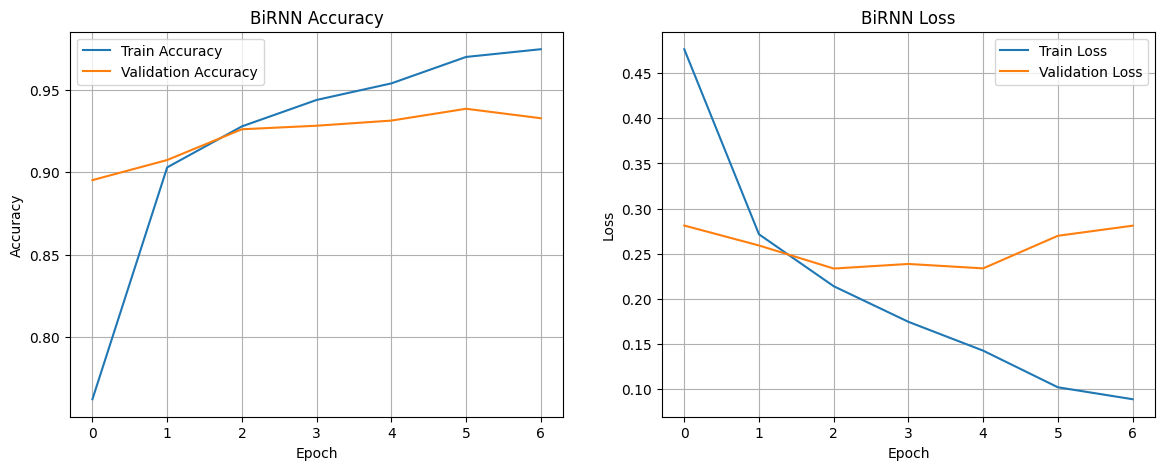

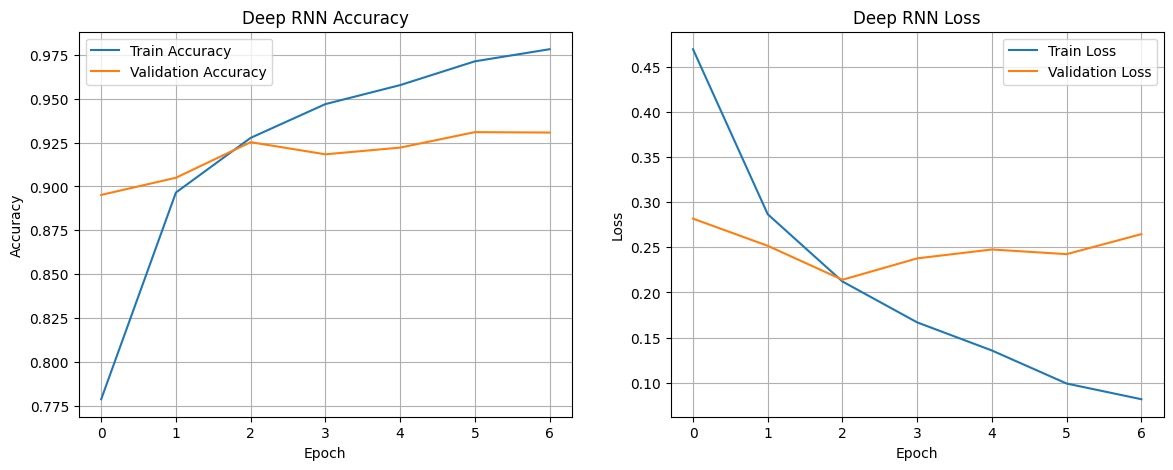

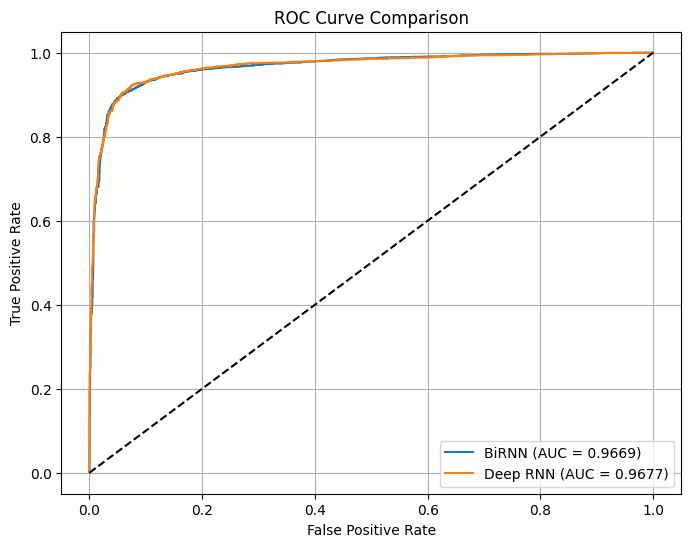

In [ ]:
# 10. PLOTTING FUNCTIONS
def plot_training(history, model_name):
    plt.figure(figsize=(14,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

def plot_roc(fpr1, tpr1, fpr2, tpr2):
    plt.figure(figsize=(8,6))
    plt.plot(fpr1, tpr1, label='BiRNN (AUC = {:.4f})'.format(metrics_birnn[4]))
    plt.plot(fpr2, tpr2, label='Deep RNN (AUC = {:.4f})'.format(metrics_deep_rnn[4]))
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC Curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Plotting
plot_training(history_birnn, "BiRNN")
plot_training(history_deep_rnn, "Deep RNN")
plot_roc(metrics_birnn[5], metrics_birnn[6], metrics_deep_rnn[5], metrics_deep_rnn[6])


In [ ]:
# 11. PRINT FINAL COMPARISON
print("\n\n=== Final Model Comparison ===")
print(f"BiRNN -> Accuracy: {metrics_birnn[0]:.4f}, Precision: {metrics_birnn[1]:.4f}, Recall: {metrics_birnn[2]:.4f}, F1: {metrics_birnn[3]:.4f}, AUC: {metrics_birnn[4]:.4f}")
print(f"Deep RNN -> Accuracy: {metrics_deep_rnn[0]:.4f}, Precision: {metrics_deep_rnn[1]:.4f}, Recall: {metrics_deep_rnn[2]:.4f}, F1: {metrics_deep_rnn[3]:.4f}, AUC: {metrics_deep_rnn[4]:.4f}")



=== Final Model Comparison ===
BiRNN -> Accuracy: 0.9206, Precision: 0.9440, Recall: 0.8943, F1: 0.9185, AUC: 0.9669
Deep RNN -> Accuracy: 0.9193, Precision: 0.9431, Recall: 0.8926, F1: 0.9171, AUC: 0.9677
